In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *

In [2]:
class KldMcl(Mcl): 
    def __init__(self, envmap, init_pose, num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05, 
                widths = np.array([0.2, 0.2, math.pi/18]).T): #範囲、ステップを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.widths = widths
        
    def bin_index(self, pose):
        return [math.floor(e) for e in pose/self.widths]
        
    def kld_sampling(self):
        ws = [e.weight for e in self.particles]    # 重みのリストを作る
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
        
        new_particles = []
        bins = {}
        for i in range(len(self.particles)):
            p = random.choices(self.particles, weights=ws)  #1つだけ選ぶ
            bins[tuple(self.bin_index(p[0].pose))] = True                 #ビンのインデックスを辞書に登録（値はなんでも良い）
            new_particles.append(copy.deepcopy(p[0]))
            
        self.particles = new_particles
        for i in range(len(self.particles)):
            self.particles[i].weight = 1.0/len(self.particles)
        
    def motion_update(self, nu, omega, time): 
        self.kld_sampling()
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行
#        self.resampling() 

In [3]:
class KldMclAgent(MclAgent): 
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(time_interval, nu, omega, particle_pose, envmap, particle_num, motion_noise_stds)
        self.pf = KldMcl(envmap, particle_pose, particle_num, motion_noise_stds) #MclからKldMclにself.pfの中身を入れ替え

<IPython.core.display.Javascript object>


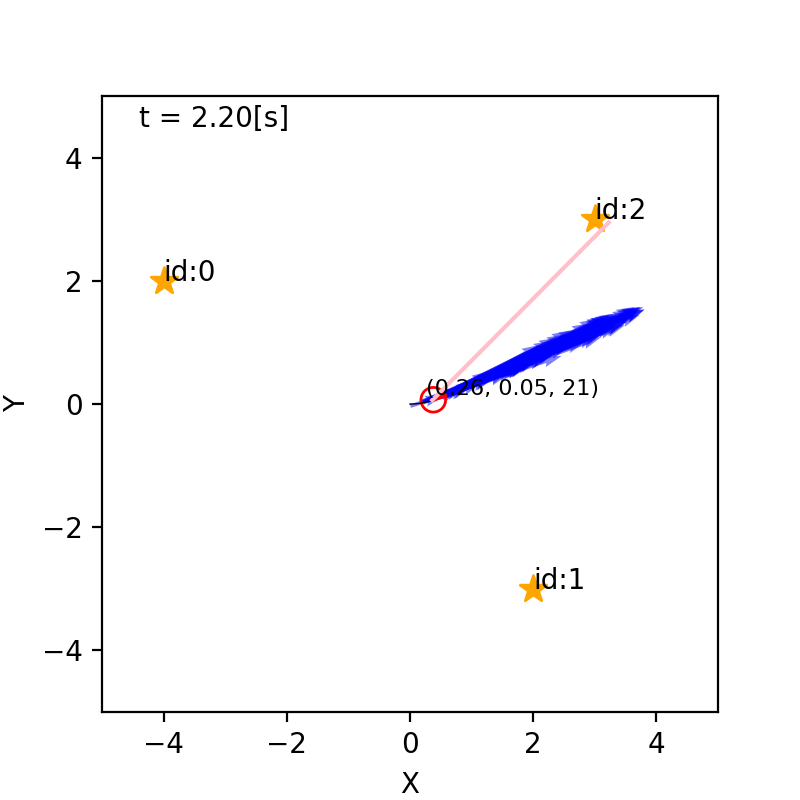

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##
    a = KldMclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100) #地図を引数で渡す
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [5]:
widths = np.array([0.2, 0.01, math.pi/18]).T
pose = np.array([-0.3, 2.1, 3]).T

[ math.floor(e) for e in pose/widths]

[-2, 210, 17]